In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# 1 - EDA and preprocessing

In [3]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
stores=pd.read_csv("stores.csv")
features=pd.read_csv("features.csv")

In [4]:
print("Train:",train.shape)
print("Test:",test.shape)
print("Stores:",stores.shape)
print("Features:",features.shape)

Train: (421570, 5)
Test: (115064, 4)
Stores: (45, 3)
Features: (8190, 12)


## 1.1 - Joining tables
- **Stores**: indicates the type and size of stores
- **Features**: indicates some characteristics for every day

In [5]:
train=train.merge(stores,on="Store")
test=test.merge(stores,on="Store")

In [6]:
train=pd.merge(train, features, how='left', on=["Store", "Date"])
test=pd.merge(test, features, how='left', on=["Store", "Date"])

In [7]:
train.drop("IsHoliday_y",axis=1,inplace=True)
test.drop("IsHoliday_y",axis=1,inplace=True)

In [8]:
train.rename(columns={"IsHoliday_x":"IsHoliday"},inplace=True)
test.rename(columns={"IsHoliday_x":"IsHoliday"},inplace=True)

In [9]:
train.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.57,nan,nan,nan,nan,nan,211.10,8.11
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.55,nan,nan,nan,nan,nan,211.24,8.11
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.51,nan,nan,nan,nan,nan,211.29,8.11
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.56,nan,nan,nan,nan,nan,211.32,8.11
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.62,nan,nan,nan,nan,nan,211.35,8.11


In [10]:
test.head(5)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.39,6766.44,5147.70,50.82,3639.90,2737.42,223.46,6.57
1,1,1,2012-11-09,False,A,151315,61.24,3.31,11421.32,3370.89,40.28,4646.79,6154.16,223.48,6.57
2,1,1,2012-11-16,False,A,151315,52.92,3.25,9696.28,292.10,103.78,1133.15,6612.69,223.51,6.57
3,1,1,2012-11-23,True,A,151315,56.23,3.21,883.59,4.17,74910.32,209.91,303.32,223.56,6.57
4,1,1,2012-11-30,False,A,151315,52.34,3.21,2460.03,nan,3838.35,150.57,6966.34,223.61,6.57


I need to build this column only for the submission file

In [11]:
submission=pd.DataFrame()
submission["Id"]=test["Store"].astype(str)+"_"+test["Dept"].astype(str)+"_"+test["Date"].astype(str)

## 1.2 - Types

In [14]:
train.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
Type             object
Size              int64
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
dtype: object

- Change Date to datetime
- Change IsHoliday to 1 and 0

In [15]:
train["Date"]=pd.to_datetime(train["Date"])
test["Date"]=pd.to_datetime(test["Date"])

In [16]:
train["IsHoliday"]=np.where(train["IsHoliday"]==True,1,0)
test["IsHoliday"]=np.where(test["IsHoliday"]==True,1,0)

## 1.3 - Categorical features

### 1.3.1 - Store, type and size

Store

In [17]:
train["Store"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

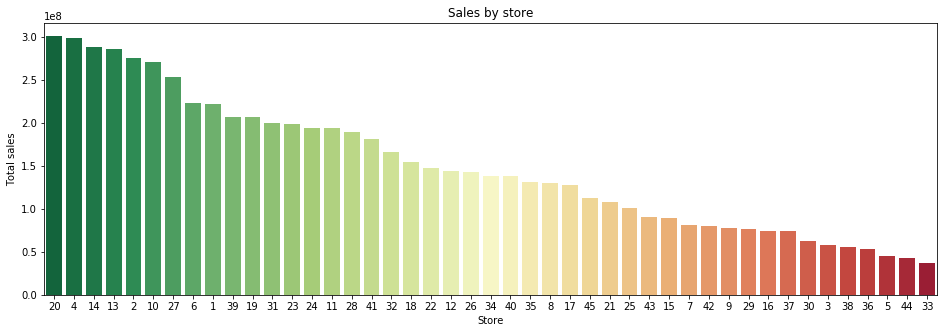

In [18]:
sales_by_store=train.groupby("Store")["Weekly_Sales"].sum().reset_index(name="Total sales").sort_values(by="Total sales",ascending=False)
plt.figure(figsize=(16,5))
sns.barplot(sales_by_store["Store"],sales_by_store["Total sales"],palette="RdYlGn_r",order=sales_by_store["Store"].tolist())
plt.title("Sales by store")
plt.show()

In [19]:
sales_by_store["Cum Sales"]=sales_by_store["Total sales"].cumsum()
sales_by_store["Pct sales"]=sales_by_store["Cum Sales"]/train["Weekly_Sales"].sum()
stores_eighty_pct_sales=sales_by_store[sales_by_store["Pct sales"]<=0.81]["Store"].tolist()
print("The first {0} stores plotted represents the 80% of the total sales".format(len(stores_eighty_pct_sales)))

The first 27 stores plotted represents the 80% of the total sales


In [20]:
train.groupby("Store")["Weekly_Sales"].sum().reset_index(name="Sales by store").set_index("Store").describe()

,Sales by store
count,45.00
mean,149715977.49
std,78167556.49
min,37160221.96
25%,79565752.43
50%,138249763.00
75%,199613905.50
max,301397792.46


Type

In [21]:
train["Type"].value_counts()/train["Type"].count()*100

A   51.11
B   38.78
C   10.10
Name: Type, dtype: float64

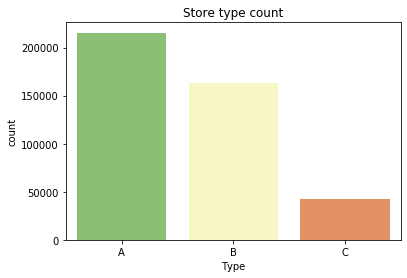

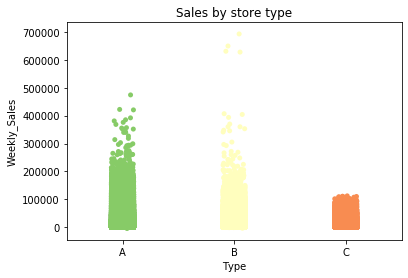

In [22]:
sns.countplot(train["Type"],palette="RdYlGn_r")
plt.title("Store type count")
plt.show()

sns.stripplot(train["Type"],train["Weekly_Sales"],palette="RdYlGn_r")
plt.title("Sales by store type")
plt.show()

In [23]:
print("Type A mean size = {0}\nType A max size = {1}\nType A min size = {2}".format(train[train["Type"]=="A"]["Size"].mean(),train[train["Type"]=="A"]["Size"].max(),train[train["Type"]=="A"]["Size"].min()))

print("Type B mean size = {0}\nType B max size = {1}\nType B min size = {2}".format(train[train["Type"]=="B"]["Size"].mean(),train[train["Type"]=="B"]["Size"].max(),train[train["Type"]=="B"]["Size"].min()))

print("Type C mean size = {0}\nType C max size = {1}\nType C min size = {2}".format(train[train["Type"]=="C"]["Size"].mean(),train[train["Type"]=="C"]["Size"].max(),train[train["Type"]=="C"]["Size"].min()))

Type A mean size = 182231.28548622134
Type A max size = 219622
Type A min size = 39690
Type B mean size = 101818.7358267837
Type B max size = 140167
Type B min size = 34875
Type C mean size = 40535.72528581825
Type C max size = 42988
Type C min size = 39690


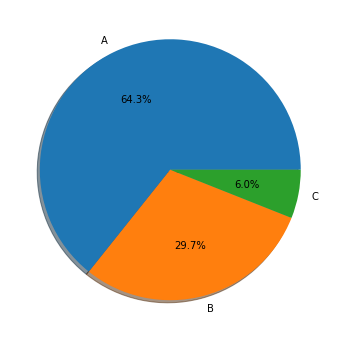

In [24]:
types_pct=(train.groupby("Type")["Weekly_Sales"].sum()/train["Weekly_Sales"].sum()*100).reset_index(name="%")
plt.figure(figsize=(6,6))
plt.pie(types_pct["%"],labels=types_pct["Type"],autopct="%1.1f%%",shadow=True)
plt.show()

- We see that there are more type A stores (51%) and C has the least quantity of stores (10%)
- The stores that sells the most are type B, and the least type C
- The type A sells 64% of the total sales, 30% B type and only a 6% C type
- The type C has a very uniform size, but A and B don't, so we can create a Size feature (Big,medium,small) in order to improve our model accuracy

*So, to do the new size feature we're going to set limits for each category:*

In [25]:
big_size=train["Size"].quantile(0.75)
small_size=train["Size"].quantile(0.25)
train["Size type"]=np.where(train["Size"]>=big_size,"Big",np.where(train["Size"]>small_size,"Medium","Small"))
test["Size type"]=np.where(test["Size"]>=big_size,"Big",np.where(test["Size"]>small_size,"Medium","Small"))

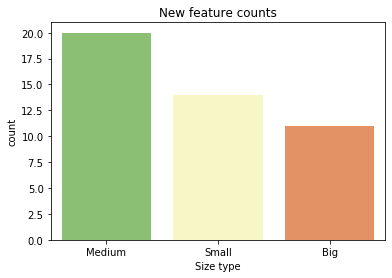

In [26]:
sns.countplot(train.groupby("Store")["Size type"].value_counts().reset_index(name="N").iloc[:,1],palette="RdYlGn_r")
plt.title("New feature counts")
plt.show()

### 1.3.2 - Dept

In [27]:
print("There are {0} departaments".format(len(train["Dept"].unique())))

There are 81 departaments


In [28]:
sales_by_dept=train.groupby("Dept")["Weekly_Sales"].sum().reset_index(name="Total sales").sort_values(by="Total sales",ascending=False)

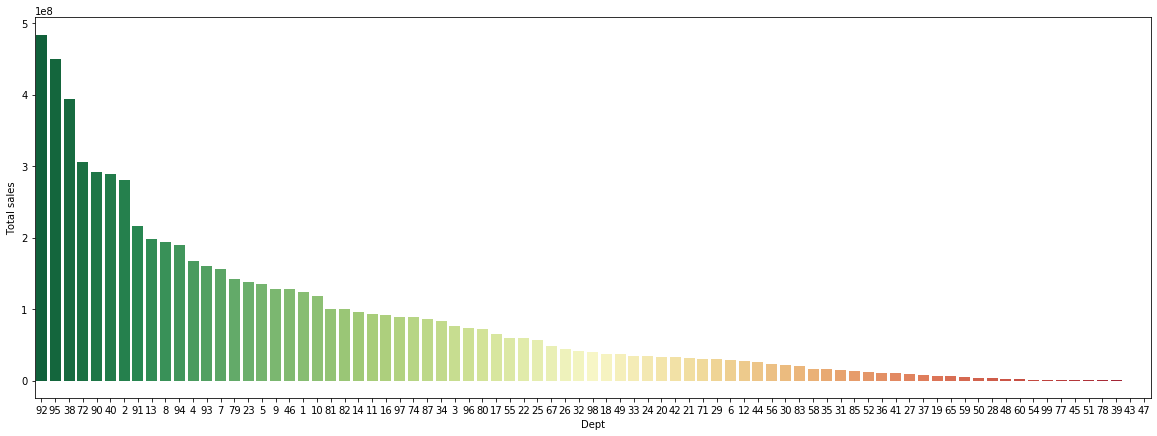

In [29]:
plt.figure(figsize=(20,7))
sns.barplot(sales_by_dept["Dept"],sales_by_dept["Total sales"],order=sales_by_dept["Dept"].tolist(),palette="RdYlGn_r")
plt.show()

In [30]:
sales_by_dept["Cum Sales"]=sales_by_dept["Total sales"].cumsum()
sales_by_dept["Pct sales"]=sales_by_dept["Cum Sales"]/train["Weekly_Sales"].sum()
dept_eighty_pct_sales=sales_by_dept[sales_by_dept["Pct sales"]<=0.81]["Dept"].tolist()
print("The first {0} departaments plotted represents the 80% of the total sales".format(len(dept_eighty_pct_sales)))

The first 29 departaments plotted represents the 80% of the total sales


In [31]:
train.groupby("Dept")["Weekly_Sales"].sum().reset_index(name="Sales by dept").set_index("Dept").describe()

,Sales by dept
count,81.00
mean,83175543.05
std,103543861.49
min,-4962.93
25%,12086936.99
50%,39828919.37
75%,117897387.58
max,483943341.87


### 1.3.3 - Date and IsHoliday

In [32]:
sales_by_date=train.groupby("Date")["Weekly_Sales"].sum().reset_index(name="Sales")

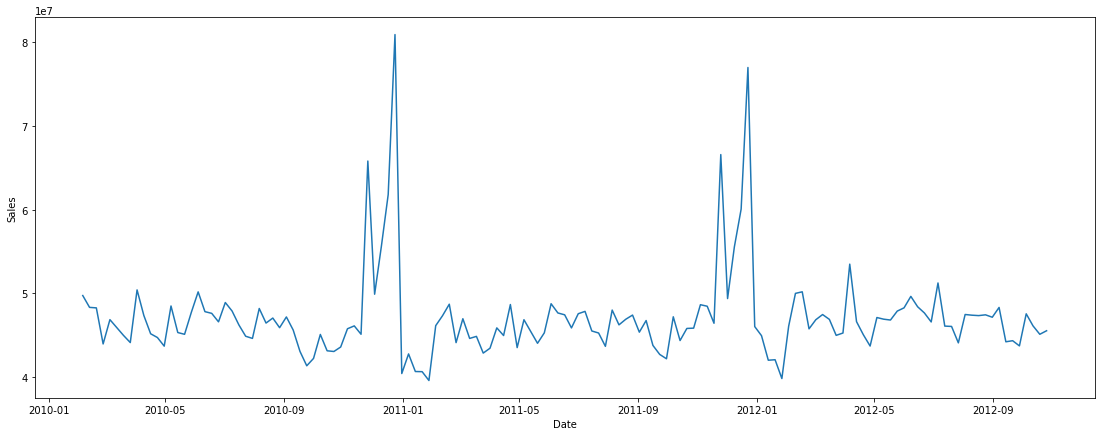

In [33]:
plt.figure(figsize=(19,7))
sns.lineplot(sales_by_date["Date"],sales_by_date["Sales"])
plt.show()

In [34]:
train["Date"].dt.weekday.unique()

array([4])

- They give us the weekly sales every Friday.
- Sales have not changed between years.

In [35]:
train["Month"]=train["Date"].dt.month
train["Week"]=train["Date"].dt.weekofyear
train["Year"]=train["Date"].dt.year

test["Month"]=test["Date"].dt.month
test["Week"]=test["Date"].dt.weekofyear
test["Year"]=test["Date"].dt.year

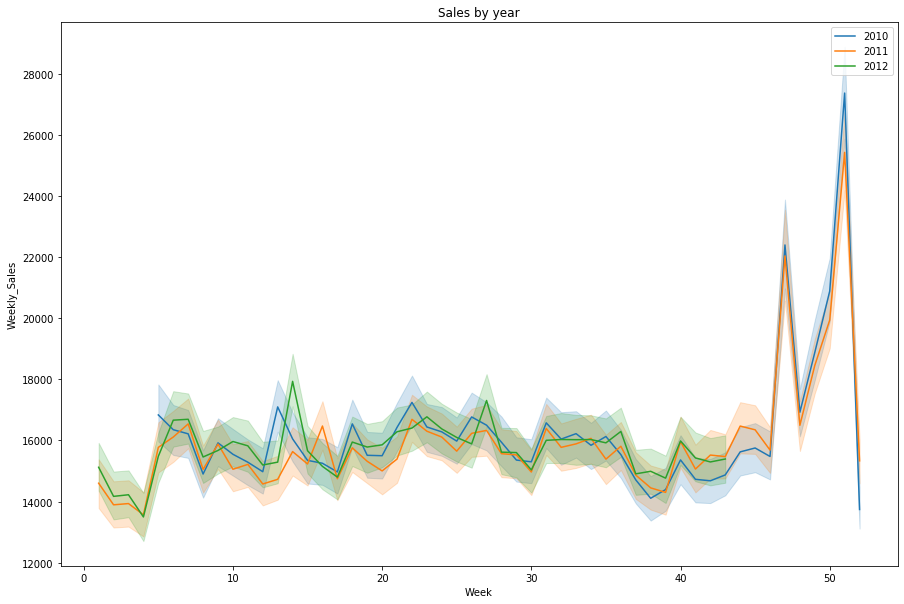

In [36]:
plt.figure(figsize=(15,10))
sns.lineplot(train[train["Year"]==2010]["Week"],train[train["Year"]==2010]["Weekly_Sales"],label="2010")
sns.lineplot(train[train["Year"]==2011]["Week"],train[train["Year"]==2011]["Weekly_Sales"],label="2011")
sns.lineplot(train[train["Year"]==2012]["Week"],train[train["Year"]==2012]["Weekly_Sales"],label="2012")
plt.title("Sales by year")
plt.legend()
plt.show()

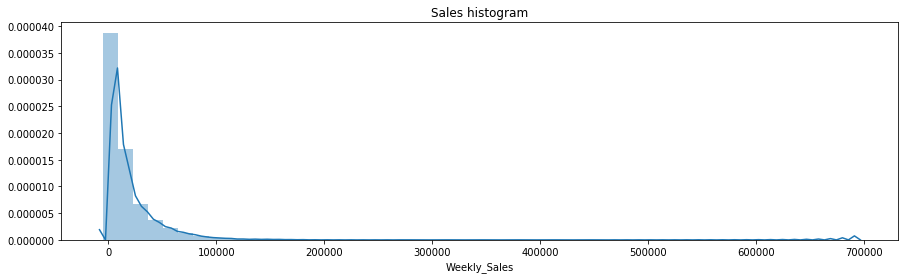

In [37]:
plt.figure(figsize=(15,4))
sns.distplot(train["Weekly_Sales"])
plt.title("Sales histogram")
plt.show()

In [38]:
holiday_sales=train[train["IsHoliday"]==1].groupby("Date")["Weekly_Sales"].sum().reset_index(name="Sales on holidays")

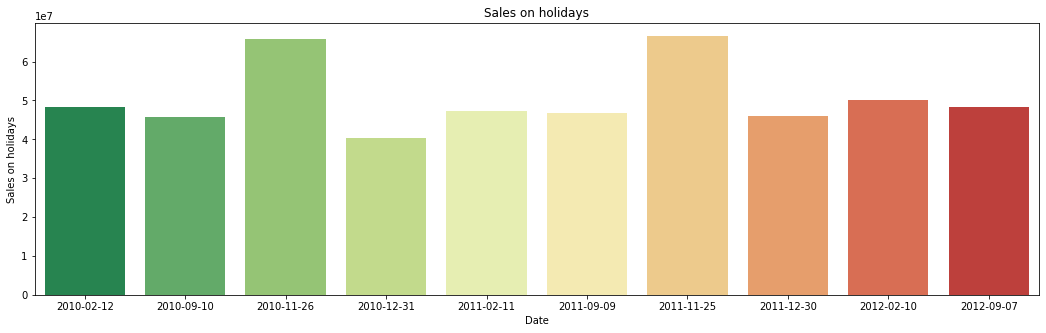

In [39]:
plt.figure(figsize=(18,5))
sns.barplot(holiday_sales["Date"].dt.date,holiday_sales["Sales on holidays"],palette="RdYlGn_r")
plt.title("Sales on holidays")
plt.show()

There are more important the weeks before holidays, so lets plot them.

In [40]:
holiday_sales["Week before holiday"]=holiday_sales["Date"].dt.date-pd.DateOffset(weeks=1)
holiday_sales["Sales week before holiday"]=train[train["Date"].isin(holiday_sales["Week before holiday"])].groupby("Date")["Weekly_Sales"].sum().reset_index(name="sales")["sales"]

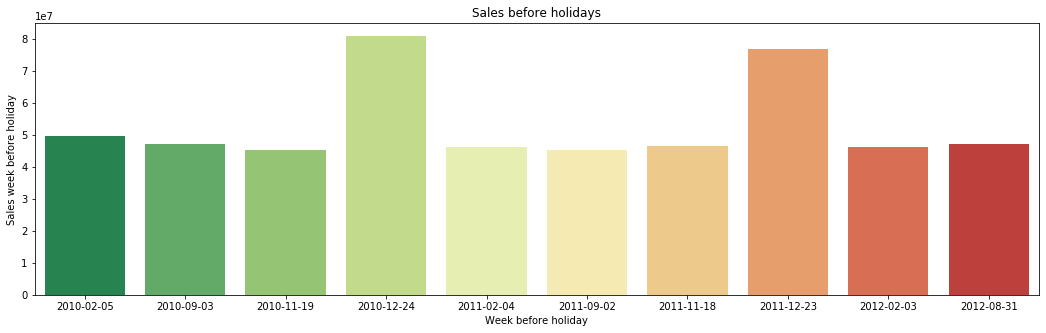

In [41]:
plt.figure(figsize=(18,5))
sns.barplot(holiday_sales["Week before holiday"].dt.date,holiday_sales["Sales week before holiday"],palette="RdYlGn_r")
plt.title("Sales before holidays")
plt.show()

We can add a new feature, that indicates that is a week before holiday

In [42]:
train["WeekHoliday"]=train["IsHoliday"].shift(-1)
train["WeekHoliday"].fillna(0,inplace=True)
train["WeekHoliday"]=train["WeekHoliday"].astype(int)

test["WeekHoliday"]=test["IsHoliday"].shift(-1)
test["WeekHoliday"].fillna(0,inplace=True)
test["WeekHoliday"]=test["WeekHoliday"].astype(int)

## 1.4 - Numeric features

### 1.4.1 - Temperature

Each Store is in a different place, so stores has different Tª in the same day. So lets take the mean for all days and plot them

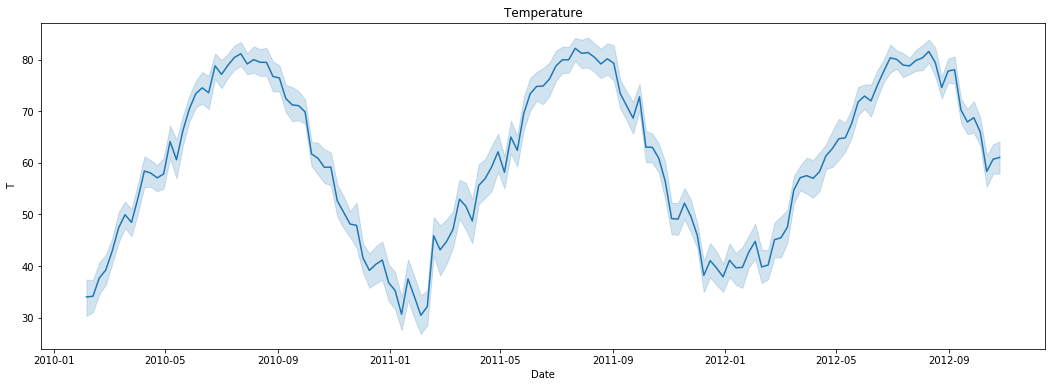

In [43]:
plt.figure(figsize=(18,6))
sns.lineplot(train.groupby(["Date","Store"])["Temperature"].mean().reset_index(name="T")["Date"],
             train.groupby(["Date","Store"])["Temperature"].mean().reset_index(name="T")["T"])
plt.title("Temperature")
plt.show()

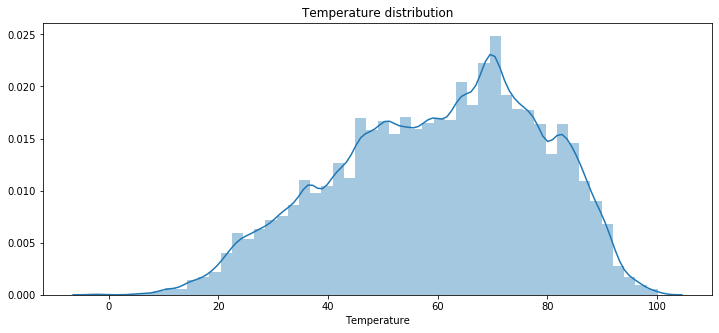

I made this graphic because I was only curious to see it. It adds nothing relevant to the analysis


In [44]:
plt.figure(figsize=(12,5))
sns.distplot(train["Temperature"])
plt.title("Temperature distribution")
plt.show()

print("I made this graphic because I was only curious to see it. It adds nothing relevant to the analysis")

### 1.4.2 - Fuel_Price

Also, the Fuel_Price varies depending the store and the date, so we take the mean to plot.

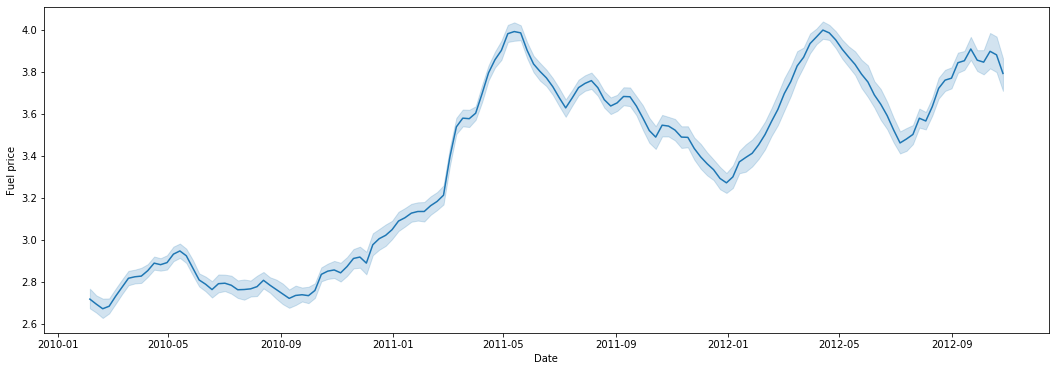

In [45]:
plt.figure(figsize=(18,6))
sns.lineplot(train.groupby(["Date","Store"])["Fuel_Price"].mean().reset_index(name="Fuel price")["Date"],
            train.groupby(["Date","Store"])["Fuel_Price"].mean().reset_index(name="Fuel price")["Fuel price"])
plt.show()

### 1.4.3 - CPI and unemployment

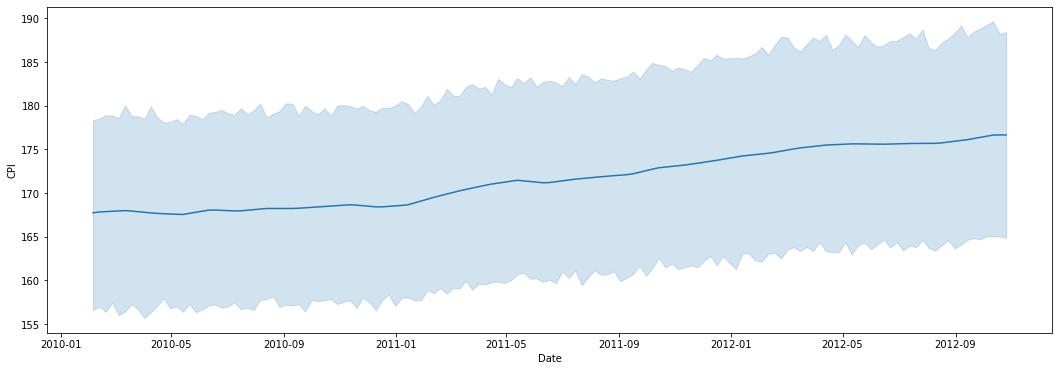

In [46]:
plt.figure(figsize=(18,6))
sns.lineplot(train.groupby(["Date","Store"])["CPI"].mean().reset_index(name="CPI")["Date"],
            train.groupby(["Date","Store"])["CPI"].mean().reset_index(name="CPI")["CPI"])
plt.show()

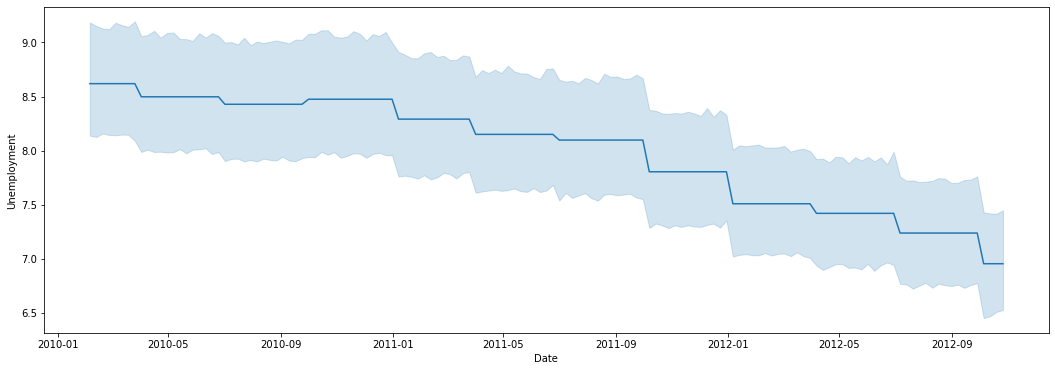

In [47]:
plt.figure(figsize=(18,6))
sns.lineplot(train.groupby(["Date","Store"])["Unemployment"].mean().reset_index(name="Unemployment")["Date"],
            train.groupby(["Date","Store"])["Unemployment"].mean().reset_index(name="Unemployment")["Unemployment"])
plt.show()

- The CPI is growing and the Unemployment is falling.
- The stores have differents CPI and Unemployments rates.

### 1.4.4 - Markdown
***MarkDown1-5:*** anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.

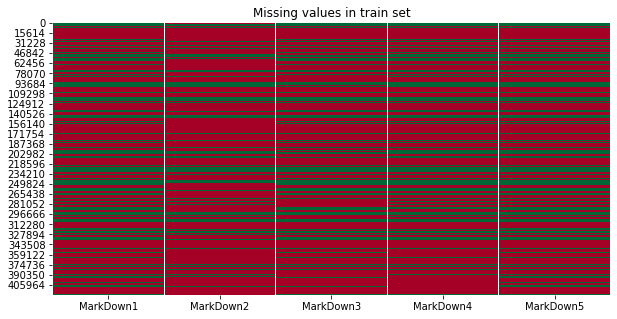

Percentage of missing values
MarkDown1   64.26
MarkDown2   73.61
MarkDown3   67.48
MarkDown4   67.98
MarkDown5   64.08
dtype: float64


In [48]:
plt.figure(figsize=(10,5))
sns.heatmap(train[["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]].isnull(),cbar=False,cmap="RdYlGn_r")
plt.title("Missing values in train set")
plt.show()

print("Percentage of missing values")
print(train[["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]].isna().sum()/len(train)*100)


In [49]:
print("There are {0} rows with some MarkDown negative".format(
    
    len(train[(train["MarkDown1"]<0) | (train["MarkDown2"]<0) | 
        (train["MarkDown3"]<0) | (train["MarkDown4"]<0) |
        (train["MarkDown5"]<0)])
))

There are 1568 rows with some MarkDown negative


- I will create a new feature TotalMarkDown.
- After runnning model, this can be a feature to tune.

### 1.4.5 - Correlations and conclusions

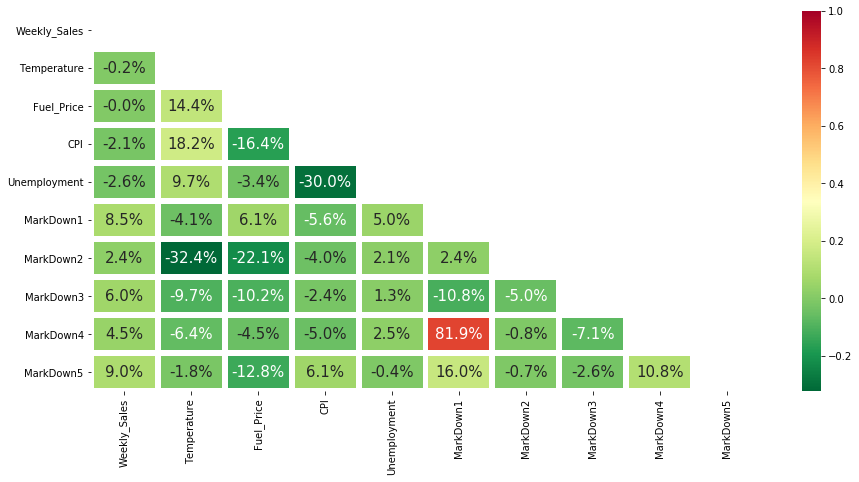

In [50]:
corr=train[["Weekly_Sales","Temperature","Fuel_Price","CPI","Unemployment",
            "MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]].corr()

plt.figure(figsize=(15,7))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,cmap="RdYlGn_r",annot=True,linewidths=5,mask=mask,fmt = '.1%',annot_kws={"size": 15})
plt.show()

- Temperature, fuel price are features that don't depend of the organization, and we saw that they are uncorrelated with the sales.

- Despite the fact that CPI has increased and Unemployment has decreased, the sales has decreased a bit, so the correlation is negative in both cases.

## 1.5 - Preprocessing

### 1.5.1 - Missing values
- The missing values on CPI and Unemployment are going to be filled with the previous value
- The missing values for markdowns are going to be filled with 0

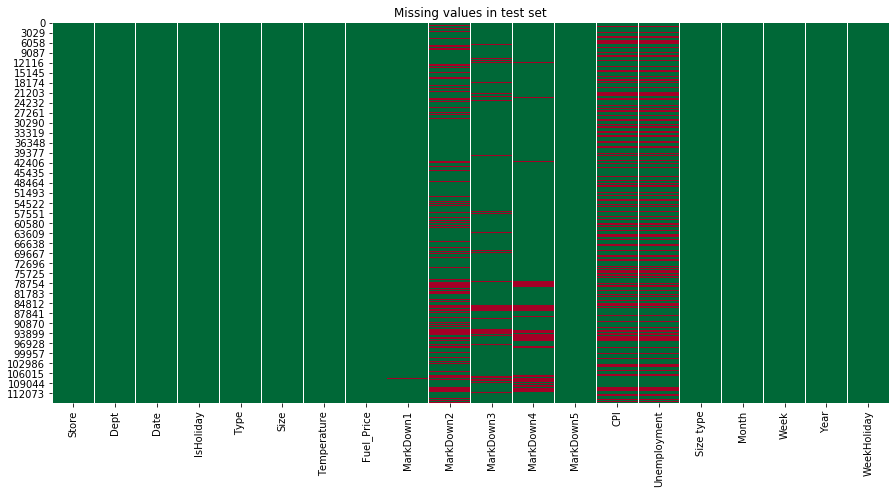

In [51]:
plt.figure(figsize=(15,7))
sns.heatmap(test.isnull(),cbar=False,cmap="RdYlGn_r")
plt.title("Missing values in test set")
plt.show()

#### 1.5.1.1 - CPI and unemployment
This is not completly correct, because each store has different values of CPI and unemployment, but I think this features are not so important and this aproximation will be ok. May be this can be modified later to see an improvement in accuracy, e.g: doing KNN or a linear regression for both.

In [52]:
test[["CPI","Unemployment"]]=test[["CPI","Unemployment"]].ffill(axis=0)

#### 1.5.1.2- Markdowns
Lets add a new feature TotalMarkDown and fill all NaNs with 0.
This is a difficult feature, because we have only a few rows with MarkDowns values on our train set, so it's very little information.
- Also agregating a NullMarkDown feature could improve our model

In [53]:
train[["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]]=train[["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]].fillna(0)
test[["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]]=test[["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]].fillna(0)

In [54]:
train["TotalMarkDown"]=train.iloc[:, -12:-7].sum(axis=1)
test["TotalMarkDown"]=test.iloc[:, -12:-7].sum(axis=1)

In [55]:
train.drop(["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"],inplace=True,axis=1)
test.drop(["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"],inplace=True,axis=1)

### 1.5.2 - Scaling

In [56]:
X_s_train=train[["Size","Temperature","CPI","Fuel_Price","Unemployment","TotalMarkDown"]]
X_s_test=test[["Size","Temperature","CPI","Fuel_Price","Unemployment","TotalMarkDown"]]

In [57]:
X=train.drop("Weekly_Sales",axis=1)

In [58]:
scaler=StandardScaler()
X[["Size","Temperature","CPI","Fuel_Price","Unemployment","TotalMarkDown"]]=scaler.fit_transform(X_s_train)
test[["Size","Temperature","CPI","Fuel_Price","Unemployment","TotalMarkDown"]]=scaler.fit_transform(X_s_test)

### 1.5.3 - Encoding categorical features

In [59]:
X=pd.get_dummies(X,columns=["Store","Dept","IsHoliday","Type","Size type","WeekHoliday"],drop_first=True)
test=pd.get_dummies(test,columns=["Store","Dept","IsHoliday","Type","Size type","WeekHoliday"],drop_first=True)

In [60]:
X.drop("Date",axis=1,inplace=True)
test.drop("Date",axis=1,inplace=True)

In [61]:
X.shape, test.shape

((421570, 139), (115064, 139))

## 1.6 - Model creation

- My computer is old and has only 4 GB Ram, and this process was taking to long.
- So a decided to tune the parameters "by eye" and couldn't do any CV (+3 hours for one CV)
- Definitively this model can be improve a lot by doing GridSearchCV, but I'm not able to do it because my computer
- The competition is evaluating with a weighted mean absolute error

In [62]:
Y=train["Weekly_Sales"]
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

In [64]:
forest2=RandomForestRegressor(n_estimators=80,
                             n_jobs=-1,
                             random_state=26,
                             max_features="sqrt",
                             min_samples_leaf=1,
                             min_samples_split=4)
forest2.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=80, n_jobs=-1, oob_score=False,
                      random_state=26, verbose=0, warm_start=False)

The competition evaluate with a Weighted Mean Abs Error, if it's a holiday weight=5, else =1

In [65]:
Y_pred_2=forest2.predict(X_test)
weights=np.where(X_test["IsHoliday_1"]==1,5,1)
WMAE=sum(weights*abs(Y_test-Y_pred_2))
WMAE=WMAE/sum(weights)
print("WMAE = {0}".format(WMAE))

WMAE = 2363.025104663179


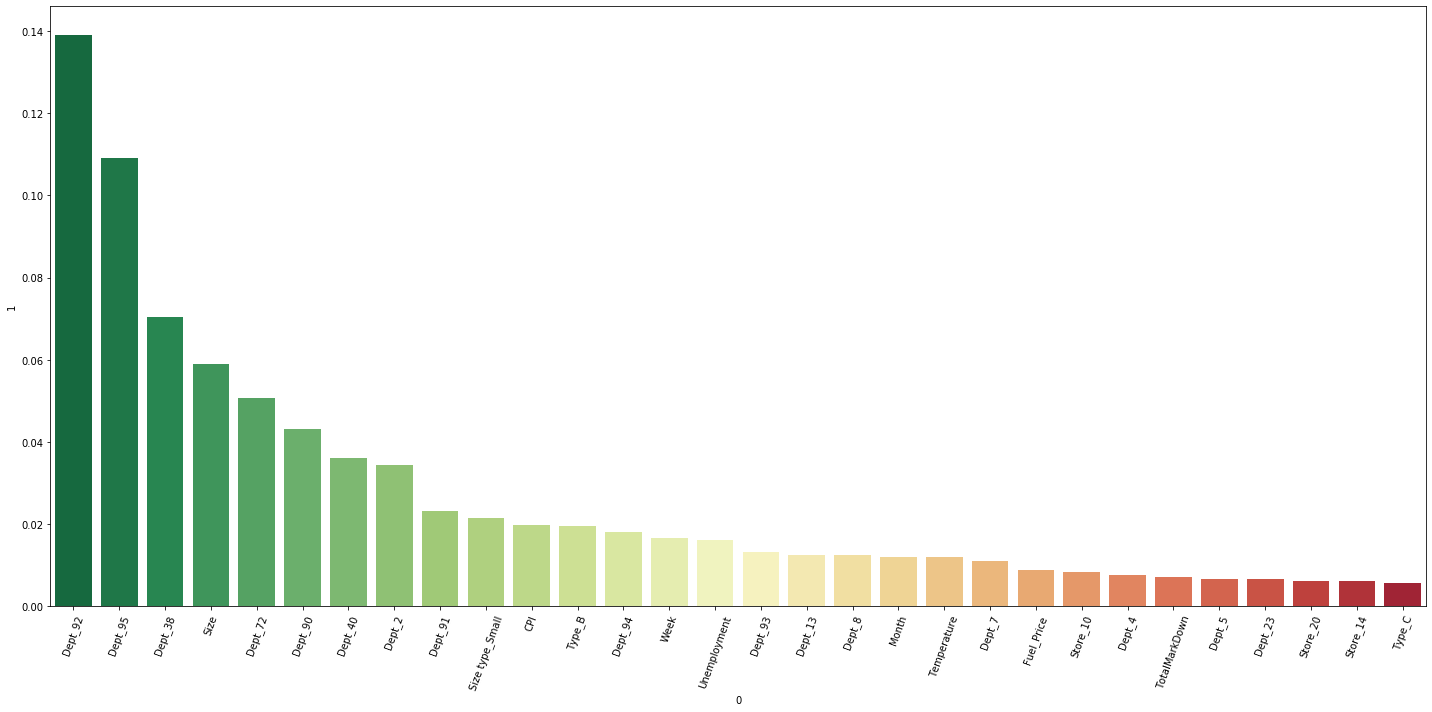

In [66]:
feature_importance=pd.DataFrame(list(zip(X.columns.values,forest2.feature_importances_)))
feature_importance=feature_importance.sort_values(by=1,ascending=False).head(30)
plt.figure(figsize=(20,10))
sns.barplot(feature_importance[0],feature_importance[1],palette="RdYlGn_r")
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

## 1.7 - Submission

The Id column is formed by concatenating the Store, Dept, and Date with underscores (e.g. Store_Dept_2012-11-02)

In [67]:
submission["Weekly_Sales"]=forest2.predict(test)

In [70]:
submission.to_csv("mysubmission.csv",index=False)